In [ ]:
## For General Processing Purposes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## For Text Preprocessing (Utilities)
import nltk
import json
import re
import spacy
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## For model Building
from sklearn.cluster import KMeans
from kneed import KneeLocator

## Extras
from collections import Counter
from itertools import chain
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

In [77]:
# Global Variables
nlp = spacy.load('en_core_web_sm')
# stopwords = stopwords.words('english')
dataset_file_path = "../data/books.csv"
n_k = range(1,41)
sse = []
min_no_of_rating = 2000000
vectorizer = TfidfVectorizer(stop_words='english')
params = {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":None,
}

In [14]:
punctuation = string.punctuation + '—'

In [3]:
df = pd.read_csv(dataset_file_path) \
    .drop(['web-scraper-order', 'web-scraper-start-url', 'genre', 'genre-href', 'book', 'book-href'], axis=1)
df.head()

,title,author,description,rating,total_rating,list_genre
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D..."
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F..."
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young..."
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti..."
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young..."


In [4]:
df.isnull().sum()

title           0
author          0
description     1
rating          0
total_rating    0
list_genre      0
dtype: int64

In [5]:
df = df.dropna(how='any')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1120 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1120 non-null   object 
 1   author        1120 non-null   object 
 2   description   1120 non-null   object 
 3   rating        1120 non-null   float64
 4   total_rating  1120 non-null   object 
 5   list_genre    1120 non-null   object 
dtypes: float64(1), object(5)
memory usage: 61.2+ KB


In [7]:
df.shape

(1120, 6)

In [8]:
df.describe()

,rating
count,1120.000000
mean,4.140589
std,0.278698
min,2.000000
25%,3.960000
50%,4.150000
75%,4.340000
max,4.890000


In [9]:
# Ratings Cleaning
df['Rating_cleaned'] = df['total_rating'].apply(lambda x:re.sub(',(?!\s+\d$)', '', x[:-8])).astype(np.int64)
df['Rating_cleaned'].head()

0    1375098
1    1747095
2    2939820
3    3435924
4    3036114
Name: Rating_cleaned, dtype: int64

In [10]:
df.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114


In [11]:
df['genre_list_cleaned'] = df['list_genre'].apply(lambda x:[dict_genre['list_genre'] for dict_genre in json.loads(x)])
df['genre_list_cleaned'] = df['genre_list_cleaned'].apply(lambda x:['-'.join(genre.split()) for genre in x[:-1]])
df.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned,genre_list_cleaned
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie..."
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict..."
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre..."
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre..."
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre..."


In [17]:
def strip_html(text):
    """
    This function strip html tags from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from html
    """
    
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stopwords(text):
    """
    This function remove stopwords from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from stopwords
    """
    
    text = text.split()
    text = [word for word in text if word not in stopwords]
    return ' '.join(text)

def remove_digits(text):
    """
    This function remove number/digits from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from number/digits
    """
    
    text = re.sub(r'[0-9]', '', text)
    return text

def remove_punctuation(text):
    """
    This function remove punctuation from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: cleaned text from punctuation
    """
    
    text = ''.join([word for word in text if word not in punctuation])
    return text

def get_keywords(text):
    """
    This function get keywords from text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: list of keywords
    """
    
    doc = nlp(text)
    return ' '.join([item.text.strip() for item in doc.ents])

def parse_text(text):
    """
    This function parse the text
    
    Parameters
    ----------
    text: some text
    
    Returns
    ----------
    text: parsed text
    """
    
    text = text.lower()
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_punctuation(text)
    text = get_keywords(text)
    return text

In [18]:
df['keywords'] = df['description'].apply(parse_text)
df.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned,genre_list_cleaned,keywords
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss new york second
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first today one one new york new moon stephani...
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter one harry dumbledore harry return...
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter summer harry harry returns harry’...
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...


In [19]:
df['keywords'][0]

'one triss new york second'

## Exploratory Data Analysis

The dataset has the following columns:
* title: The title of the book
* author: The author of the book
* description: The description of the book
* rating: The rating of the book
* total_rating: The total number of ratings of the book
* list_genre : genre of the book

In [20]:
print(f'The goodreads dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

The goodreads dataset contains 1120 rows and 9 columns


In [21]:
df.dropna(inplace=True)
print(f'After dropping missing value, the goodreads dataset contains {df.shape[0]} rows and {df.shape[1]} columns')

After dropping missing value, the goodreads dataset contains 1120 rows and 9 columns


In [22]:
print('Book unique value:', len(df['title'].unique()))
print('Author unique value:', len(df['author'].unique()))

Book unique value: 1120
Author unique value: 898


In [30]:
def bar(x,y,title=None,sc=False,xlabel=None,ylabel=None,figsize=(10,10)):
    plt.figure(figsize=(15,8))
    if not sc:
        plt.ticklabel_format(style='plain', axis='x')
    ax = sns.barplot(x=x, y=y, palette='mako')
    ax.set_title(title, pad=20, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

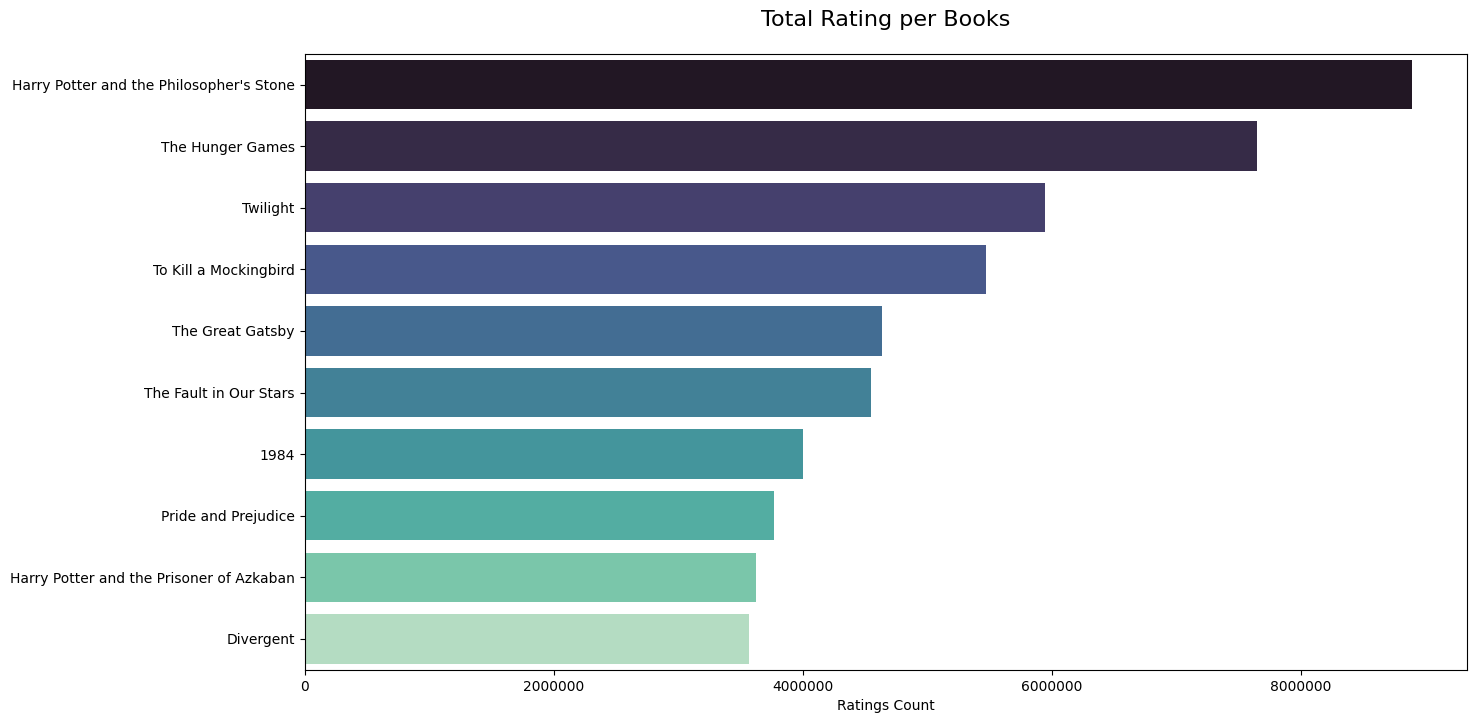

In [31]:
top_10_rated_book = df.sort_values('Rating_cleaned', ascending=False).head(10).set_index('title')
bar(
    x=top_10_rated_book['Rating_cleaned'], 
    y=top_10_rated_book.index, 
    title='Total Rating per Books',
    xlabel='Ratings Count'
)

JK Rowling got some of the most rated books in the dataset present.

In [39]:
rating_mean = np.mean(df['Rating_cleaned'])
min_rating = np.min(df['Rating_cleaned'])

def weighted_rating(R, v, C=rating_mean, m=min_rating):    
    return (R * v) + (C * m) / (v + m)

df['weighted_rating'] = weighted_rating(df['rating'], df['Rating_cleaned']) / 1e6
df.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned,genre_list_cleaned,keywords,weighted_rating
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss new york second,5.486641
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first today one one new york new moon stephani...,6.254600
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter one harry dumbledore harry return...,13.464376
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter summer harry harry returns harry’...,15.221143
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...,13.662513


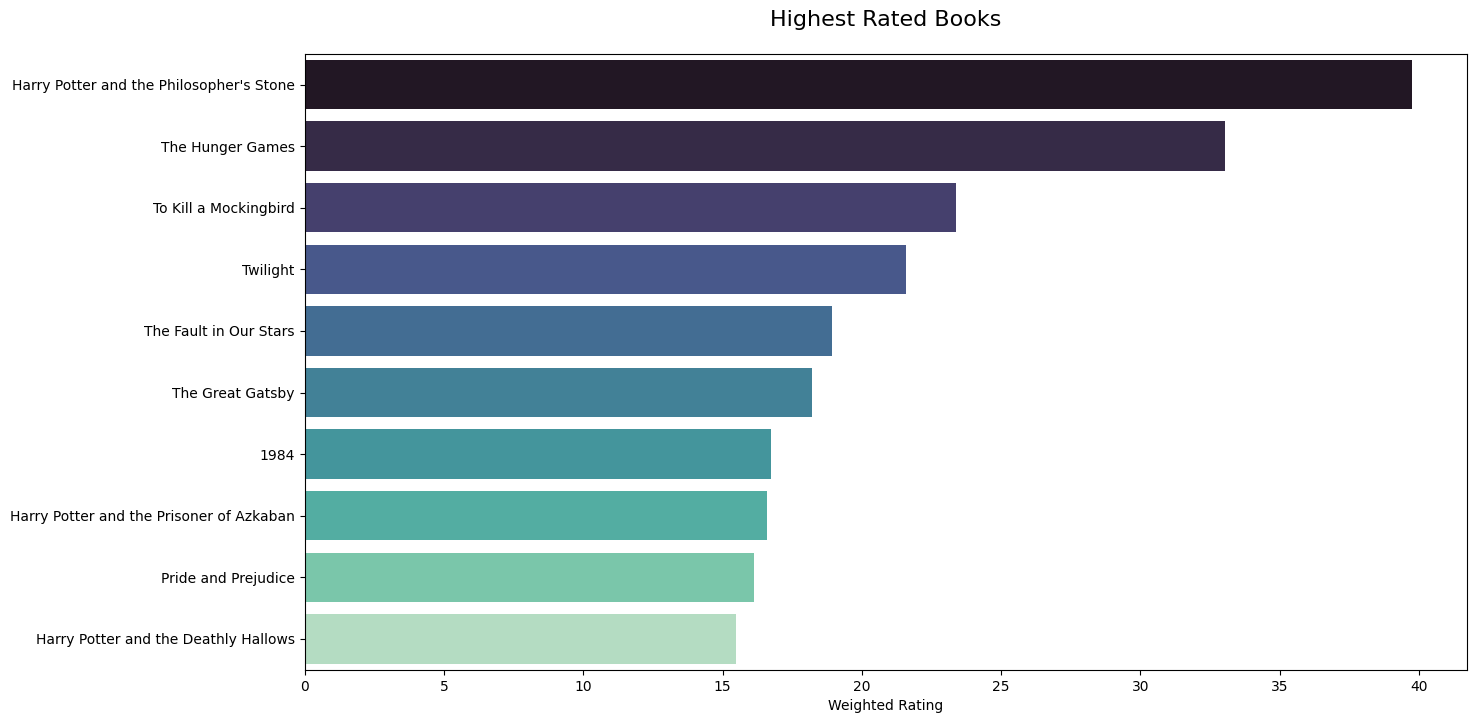

In [41]:
top_10_books = df.sort_values('weighted_rating', ascending=False).head(10).set_index('title')
bar(
    x=top_10_books['weighted_rating'], 
    y=top_10_books.index, 
    title='Highest Rated Books',
    xlabel='Weighted Rating'
)

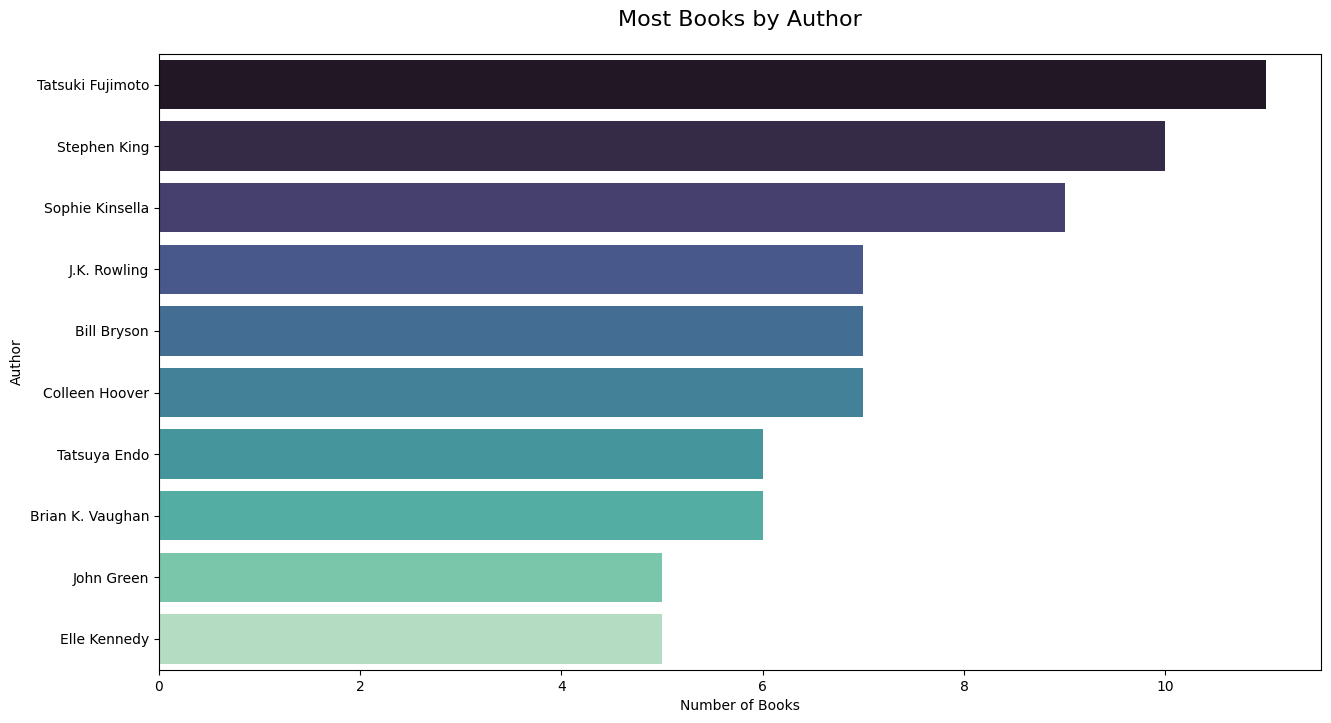

In [44]:
top_10_authors = df['author'].value_counts().sort_values(ascending=False)[:10]
bar(
    x = top_10_authors.values,
    y = top_10_authors.index,
    title="Most Books by Author",
    xlabel="Number of Books",
    ylabel="Author",
)

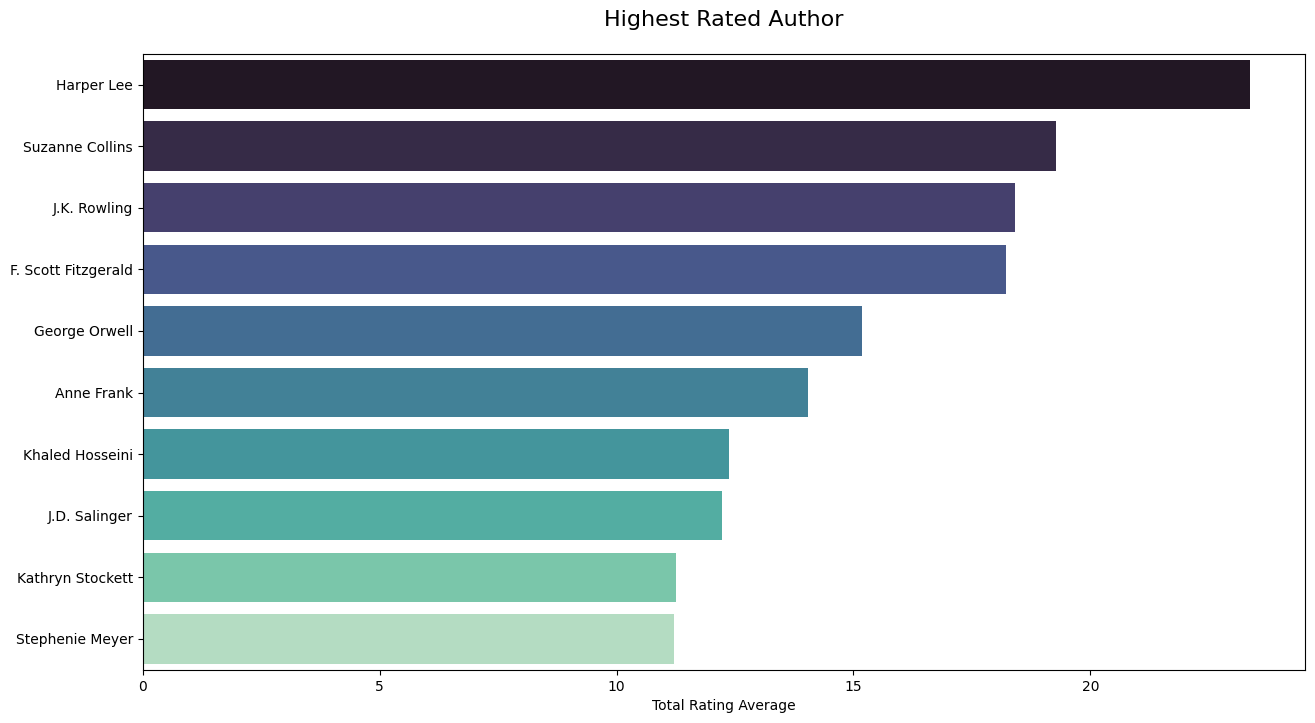

In [46]:
top_rated_author = df.groupby('author')['weighted_rating'].agg(np.mean).sort_values(ascending=False)[:10]
bar(
    y=top_rated_author.index, 
    x=top_rated_author.values, 
    title='Highest Rated Author',
    xlabel='Total Rating Average'
)

In [49]:
df.columns

Index(['title', 'author', 'description', 'rating', 'total_rating',
       'list_genre', 'Rating_cleaned', 'genre_list_cleaned', 'keywords',
       'weighted_rating'],
      dtype='object')

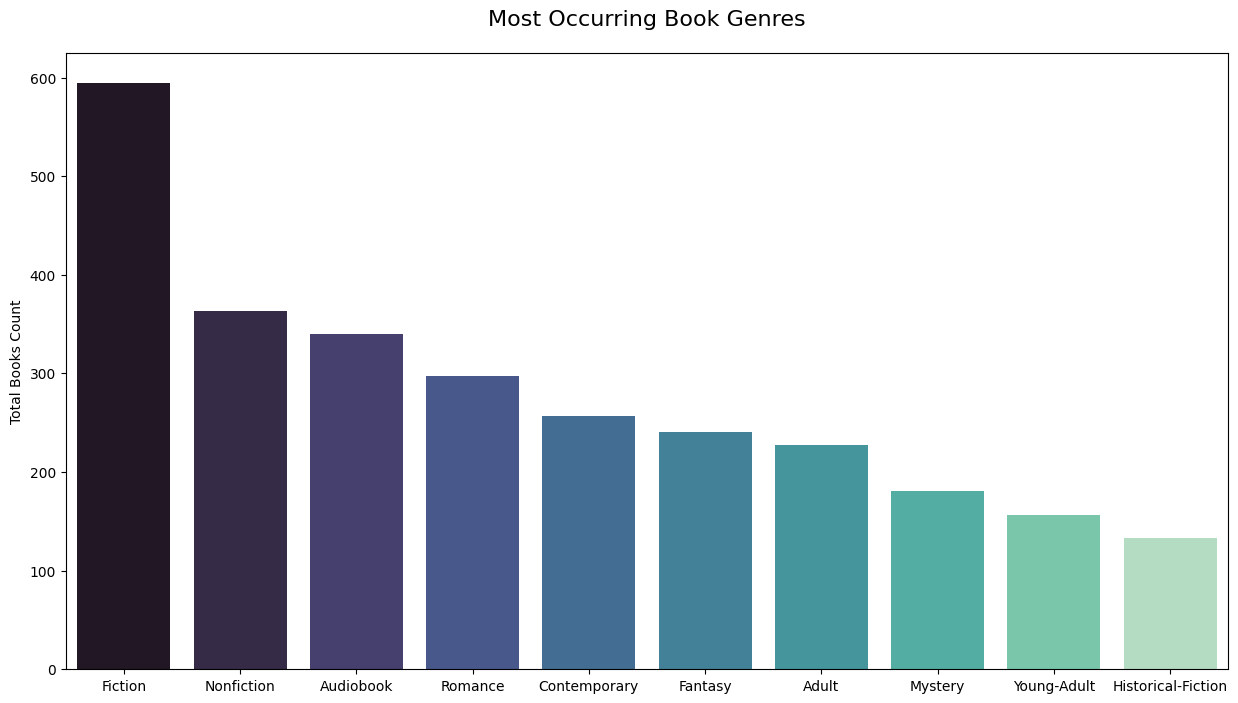

In [50]:
genre_list = df['genre_list_cleaned'].values
genres = list(chain.from_iterable(genre_list))
top_10_genre = Counter(genres).most_common(10)
bar(
    x=[genre for (genre, count) in top_10_genre],
    y=[count for (genre, count) in top_10_genre],
    title='Most Occurring Book Genres',
    ylabel='Total Books Count'
)

In [52]:
top_genre = ['Fiction']
fiction_book = df.loc[df['genre_list_cleaned'].apply(lambda x: any(set(x).intersection(top_genre)))]
fiction_book.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned,genre_list_cleaned,keywords,weighted_rating
0,Insurgent,Veronica Roth,One choice can transform you—or it can destroy...,3.99,"1,375,098 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""D...",1375098,"[Young-Adult, Dystopia, Fiction, Fantasy, Scie...",one triss new york second,5.486641
1,New Moon,Stephenie Meyer,There is an alternate cover edition for ISBN13...,3.58,"1,747,095 ratings","[{""list_genre"":""Young Adult""},{""list_genre"":""F...",1747095,"[Young-Adult, Fantasy, Romance, Vampires, Fict...",first today one one new york new moon stephani...,6.254600
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"It is the middle of the summer, but there is a...",4.58,"2,939,820 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",2939820,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter one harry dumbledore harry return...,13.464376
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Ever since Harry Potter had come home for the ...,4.43,"3,435,924 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Ficti...",3435924,"[Fantasy, Fiction, Young-Adult, Magic, Childre...",harry potter summer harry harry returns harry’...,15.221143
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Harry Potter is about to start his fifth year ...,4.50,"3,036,114 ratings","[{""list_genre"":""Fantasy""},{""list_genre"":""Young...",3036114,"[Fantasy, Young-Adult, Fiction, Magic, Childre...",harry potter fifth year summer holidays summer...,13.662513


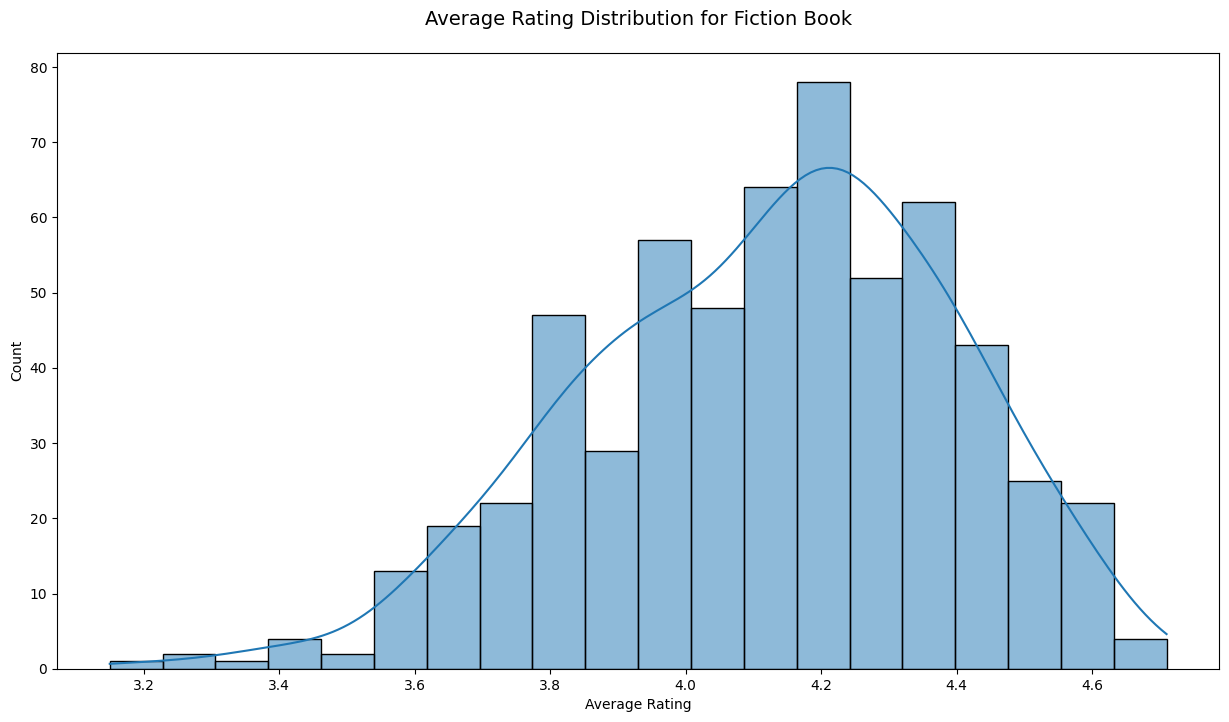

In [53]:
plt.figure(figsize=(15,8))
sns.histplot(data=fiction_book, x='rating', kde=True, bins=20)
plt.title('Average Rating Distribution for Fiction Book', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.show()

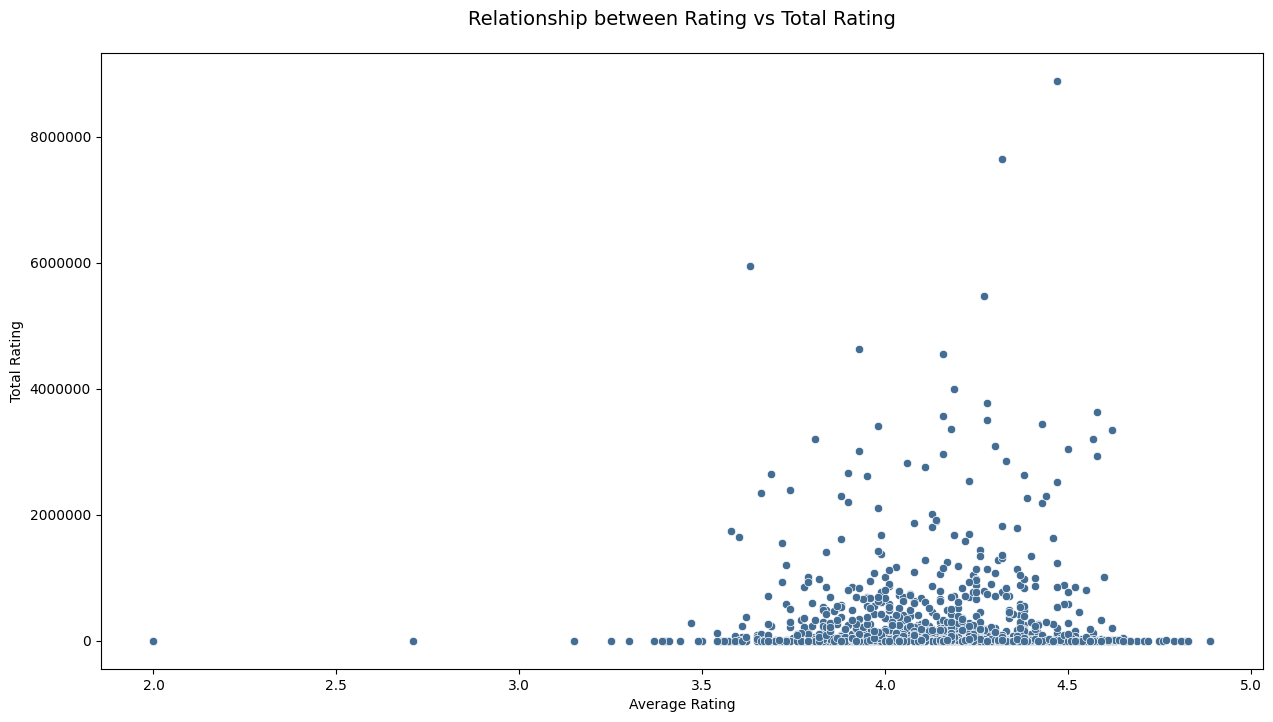

In [57]:
# Relation between rating and total rating
plt.figure(figsize=(15,8))
sns.scatterplot(y='Rating_cleaned', x='rating', data=df, color='#436D93')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Relationship between Rating vs Total Rating', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Total Rating')
plt.show()


In [60]:
temp = df[~(df['Rating_cleaned'] > min_rating)]
temp.head()

,title,author,description,rating,total_rating,list_genre,Rating_cleaned,genre_list_cleaned,keywords,weighted_rating
390,Truth Changes Everything: How People of Faith ...,Jeff Myers,America has passed a tipping point. A majority...,3.5,2 ratings,"[{""list_genre"":""Nonfiction""},{""list_genre"":""Re...",2,"[Nonfiction, Religion]",america americans dr jeff myers,0.147074
394,Does Scripture Speak for Itself?: The Museum o...,Jill Hicks-Keeton,Is the Bible the unembellished Word of God or ...,2.0,2 ratings,"[{""list_genre"":""Religion""}]",2,[],christianity american washington,0.147071


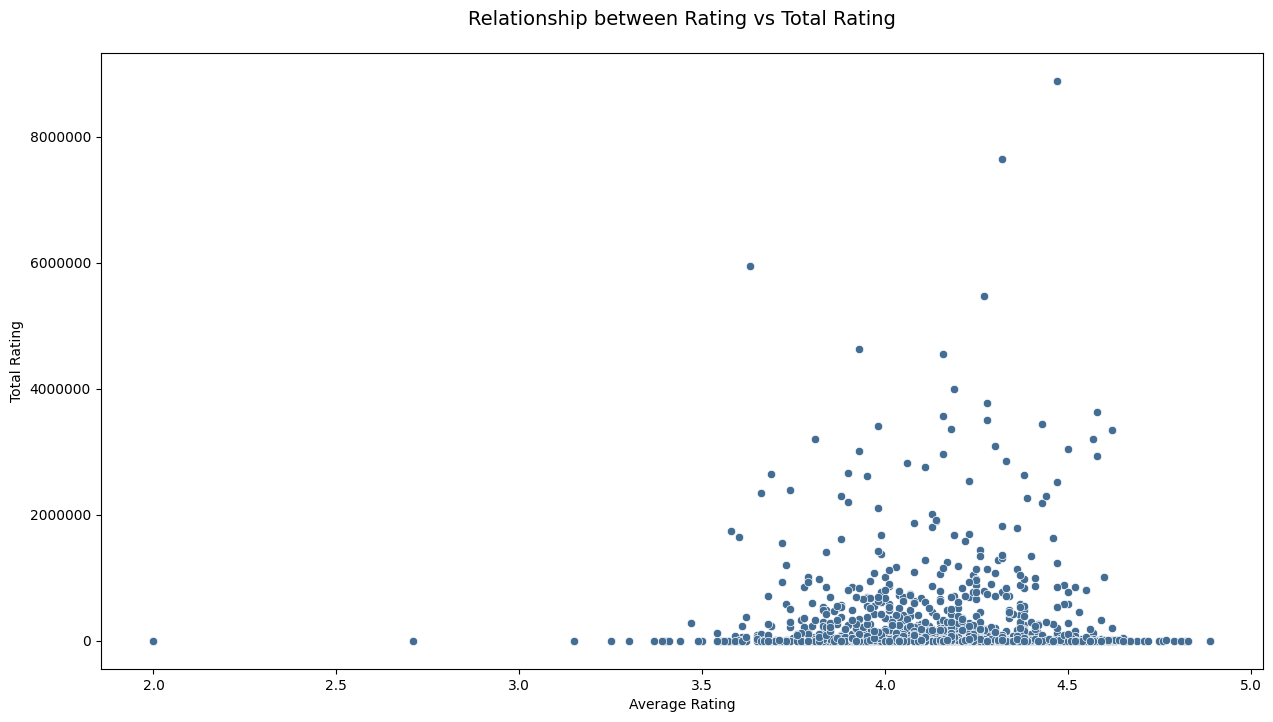

In [61]:
# Relation between rating and total rating
plt.figure(figsize=(15,8))
sns.scatterplot(y='Rating_cleaned', x='rating', data=df, color='#436D93')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Relationship between Rating vs Total Rating', pad=20, fontsize=14)
plt.xlabel('Average Rating')
plt.ylabel('Total Rating')
plt.show()


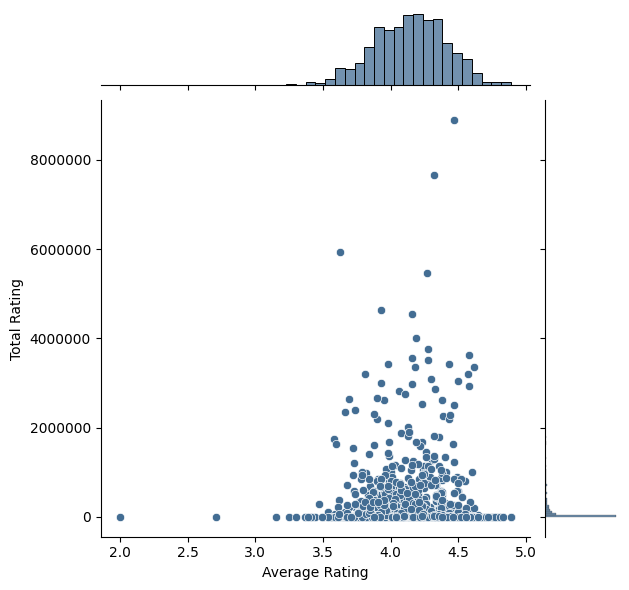

In [64]:
ax = sns.jointplot(x='rating', y='Rating_cleaned', data=df, color='#436D93')
plt.ticklabel_format(style='plain', axis='y')
ax.set_axis_labels('Average Rating', 'Total Rating')
plt.show()

The more numeber of rating, the more good the rating is.

In [68]:
features = ['title', 'author', 'genre_list_cleaned', 'keywords']
final_df = df.loc[:, features]
final_df['genre_list_cleaned'] = final_df['genre_list_cleaned'].apply(lambda x: ' '.join(x))
final_df['keywords'] = final_df['keywords'].apply(lambda x: ' '.join(list(set(x.split()))))
final_df.head()

,title,author,genre_list_cleaned,keywords
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one york second new triss
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie first york meyer new today moon
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,one harry sixth dumbledore harrys returns year...
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,summer one draco harry harry’s year returns se...
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays fifth hermione harry year pott...


In [71]:
final_df['corpus'] =  final_df[['genre_list_cleaned', 'keywords']].agg(' '.join, axis=1).str.lower()
final_df.head()

,title,author,genre_list_cleaned,keywords,corpus
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one york second new triss,young-adult dystopia fiction fantasy science-f...
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie first york meyer new today moon,young-adult fantasy romance vampires fiction p...
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,one harry sixth dumbledore harrys returns year...,fantasy young-adult fiction magic childrens ad...
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,summer one draco harry harry’s year returns se...,fantasy fiction young-adult magic childrens mi...
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays fifth hermione harry year pott...,fantasy young-adult fiction magic childrens ad...


In [73]:
tfidf_mat = vectorizer.fit_transform(final_df['corpus'])
tfidf_mat.shape

(1120, 3381)

In [74]:
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119
0,1.000000,0.220199,0.166263,0.156809,0.174269,0.239533,0.152994,0.169581,0.143557,0.330405,...,0.065691,0.082740,0.0,0.0,0.0,0.125545,0.116331,0.000000,0.067978,0.097418
1,0.220199,1.000000,0.063966,0.062340,0.067046,0.092155,0.058861,0.065242,0.095870,0.614369,...,0.042646,0.045872,0.0,0.0,0.0,0.043873,0.038797,0.111504,0.044861,0.057667
2,0.166263,0.063966,1.000000,0.554262,0.443570,0.546794,0.377790,0.418749,0.479743,0.092264,...,0.016419,0.023017,0.0,0.0,0.0,0.000000,0.034492,0.000000,0.039884,0.013432
3,0.156809,0.062340,0.554262,1.000000,0.512410,0.574352,0.482376,0.583283,0.721909,0.158300,...,0.016002,0.022432,0.0,0.0,0.0,0.043250,0.033616,0.000000,0.038870,0.013091
4,0.174269,0.067046,0.443570,0.512410,1.000000,0.573125,0.616402,0.626189,0.502845,0.096707,...,0.017210,0.024126,0.0,0.0,0.0,0.000000,0.036153,0.000000,0.041805,0.014079


In [78]:
for k in n_k:
    print(f'Cluster {k}/40')
    kmeans = KMeans(n_clusters=k, **params)
    kmeans.fit(cosine_sim)
    sse.append(kmeans.inertia_)
    clear_output(wait=True)
locator = KneeLocator(n_k, sse, curve='convex', direction='decreasing')
print('Best cluster for KMeans:', locator.elbow)

Best cluster for KMeans: 8


In [80]:
kmeans = KMeans(n_clusters=locator.elbow, **params)
kmeans.fit(cosine_sim)
final_df['cluster'] = kmeans.labels_
final_df.head()

,title,author,genre_list_cleaned,keywords,corpus,cluster
0,Insurgent,Veronica Roth,Young-Adult Dystopia Fiction Fantasy Science-F...,one york second new triss,young-adult dystopia fiction fantasy science-f...,1
1,New Moon,Stephenie Meyer,Young-Adult Fantasy Romance Vampires Fiction P...,one stephanie first york meyer new today moon,young-adult fantasy romance vampires fiction p...,1
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,one harry sixth dumbledore harrys returns year...,fantasy young-adult fiction magic childrens ad...,1
3,Harry Potter and the Chamber of Secrets,J.K. Rowling,Fantasy Fiction Young-Adult Magic Childrens Mi...,summer one draco harry harry’s year returns se...,fantasy fiction young-adult magic childrens mi...,1
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,Fantasy Young-Adult Fiction Magic Childrens Ad...,summer holidays fifth hermione harry year pott...,fantasy young-adult fiction magic childrens ad...,1


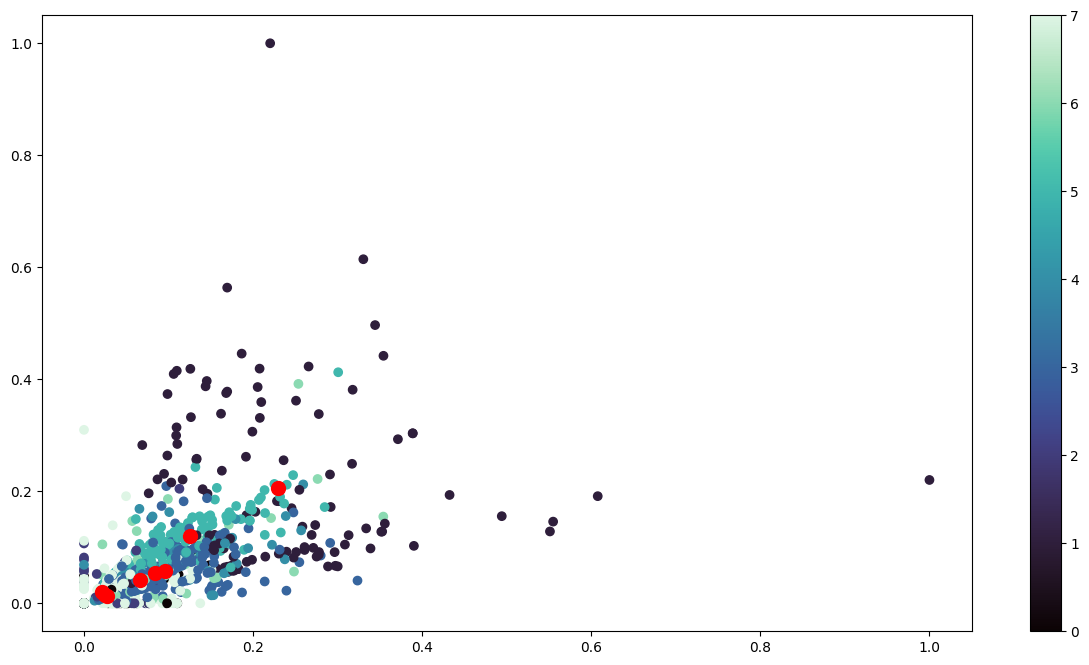

In [81]:
plt.figure(figsize=(15,8))
output = plt.scatter(cosine_sim[:,0], cosine_sim[:,1], c=final_df.cluster, marker='o', alpha=1, cmap='mako')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=100, alpha=1 , marker='o')
plt.colorbar(output)
plt.show()

In [82]:
cluster_4 = final_df.loc[final_df['cluster'] == 4, :]
cluster_4.head()

,title,author,genre_list_cleaned,keywords,corpus,cluster
76,The Flamingo: A Graphic Novel Chapter Book,Guojing,Graphic-Novels Middle-Grade Childrens Picture-...,,graphic-novels middle-grade childrens picture-...,4
288,"Saga, Volume 10",Brian K. Vaughan,Graphic-Novels Comics Fantasy Science-Fiction ...,first six,graphic-novels comics fantasy science-fiction ...,4
435,I Will Judge You by Your Bookshelf,Grant Snider,Graphic-Novels Comics Nonfiction Humor Books-A...,snider explores york new times,graphic-novels comics nonfiction humor books-a...,4
444,Big Panda & Tiny Dragon - Special Edition,James Norbury,Fiction Graphic-Novels Philosophy Self-Help Po...,james,fiction graphic-novels philosophy self-help po...,4
529,Gender Queer: A Memoir,Maia Kobabe,Graphic-Novels LGBT Memoir Nonfiction Queer Co...,kobabe maia,graphic-novels lgbt memoir nonfiction queer co...,4


In [83]:
book_map = pd.Series(final_df.index, index=final_df['title'])
book_map.head()

title
Insurgent                                    0
New Moon                                     1
Harry Potter and the Half-Blood Prince       2
Harry Potter and the Chamber of Secrets      3
Harry Potter and the Order of the Phoenix    4
dtype: int64

In [93]:
def get_recommendation(title, top_n=11):
    """
    This function get recommendation from given book title
    
    Parameters
    ----------
    title: a text of book title
    top_n: (default 11) how much book want to get recommendation - given book title
    
    Returns
    ----------
    top_n_recommendation: a DataFrame contains recommended book
    """
    
    # get index from input title
    book_id = book_map[title]
    
    # calculate similarity score, sort value descending and get top_n book
    sim_score = list(enumerate(cosine_sim[book_id]))
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)
    sim_score = sim_score[:top_n]
    
    # get book index from top_n recommendation
    book_indices = [score[0] for score in sim_score]
    scores = [score[1] for score in sim_score]
    top_n_recommendation = final_df[['title', 'author', 'genre_list_cleaned']].iloc[book_indices]
    top_n_recommendation['genre_list_cleaned'] = top_n_recommendation['genre_list_cleaned'].apply(lambda x: x.split())
    top_n_recommendation['score'] = scores
    return top_n_recommendation.iloc[1:]

In [94]:
test_book = final_df.sample(1, random_state=123)
test_book

,title,author,genre_list_cleaned,keywords,corpus,cluster
685,You Deserve Each Other,Sarah Hogle,Romance Contemporary Contemporary-Romance Adult Fiction Chick-Lit Audiobook,fiancé months two three nicholas,romance contemporary contemporary-romance adult fiction chick-lit audiobook fiancé months two three nicholas,5


In [95]:
test_title = test_book['title'].values[0]
pd.set_option('display.max_colwidth', None)
test_df = final_df[['title', 'author', 'genre_list_cleaned', 'cluster']].loc[final_df['title'] == test_title]
test_df['genre_list_cleaned'] = test_df['genre_list_cleaned'].apply(lambda x: x.split())
test_df

,title,author,genre_list_cleaned,cluster
685,You Deserve Each Other,Sarah Hogle,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, Chick-Lit, Audiobook]",5


In [99]:
recommendation = get_recommendation(test_title)
recommendation

,title,author,genre_list_cleaned,score
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.575090
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.573475
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.571532
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.549747
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.548048
338,The Unhoneymooners,Christina Lauren,"[Romance, Contemporary, Fiction, Contemporary-Romance, Adult, Chick-Lit, Audiobook]",0.547799
1036,Something Borrowed,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Contemporary-Romance, Adult-Fiction]",0.485028
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.441014
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.428116
339,It Ends with Us,Colleen Hoover,"[Romance, Contemporary, Fiction, New-Adult, Contemporary-Romance, Adult, Audiobook]",0.421226


In [100]:
recommendation['cluster'] = recommendation['title'].apply(
    lambda x: final_df.loc[final_df['title'] == x, 'cluster'].values[0] \
    if x in final_df['title'].values.tolist() else False)
recommendation

,title,author,genre_list_cleaned,score,cluster
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.575090,5
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.573475,5
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.571532,5
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.549747,5
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.548048,5
338,The Unhoneymooners,Christina Lauren,"[Romance, Contemporary, Fiction, Contemporary-Romance, Adult, Chick-Lit, Audiobook]",0.547799,5
1036,Something Borrowed,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Contemporary-Romance, Adult-Fiction]",0.485028,5
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.441014,5
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.428116,5
339,It Ends with Us,Colleen Hoover,"[Romance, Contemporary, Fiction, New-Adult, Contemporary-Romance, Adult, Audiobook]",0.421226,5


For evaluation Content Based Approach, we gonna use precision@k. Basically, count the relevant item from all recommended item. Usually precision@k use the rating, since we dont have a rating from user we gonna use the similarity score between recommended book and given book. If the score > 0,5 then the book is relevant.

In [101]:
eval_title = 'Harry Potter and the Chamber of Secrets'
high_score = get_recommendation(eval_title)
high_score

,title,author,genre_list_cleaned,score
8,Harry Potter and the Philosopher's Stone,J.K. Rowling,"[Fantasy, Fiction, Young-Adult, Magic, Childrens, Middle-Grade, Classics]",0.721909
7,Harry Potter and the Goblet of Fire,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Middle-Grade, Adventure]",0.583283
5,Harry Potter and the Deathly Hallows,J.K. Rowling,"[Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook, Fantasy]",0.574352
2,Harry Potter and the Half-Blood Prince,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook]",0.554262
4,Harry Potter and the Order of the Phoenix,J.K. Rowling,"[Fantasy, Young-Adult, Fiction, Magic, Childrens, Adventure, Audiobook]",0.512410
6,Harry Potter and the Prisoner of Azkaban,J.K. Rowling,"[Fantasy, Fiction, Young-Adult, Magic, Childrens, Middle-Grade, Adventure]",0.482376
625,Beyond the Wand: The Magic and Mayhem of Growing Up a Wizard,Tom Felton,"[Nonfiction, Memoir, Audiobook, Biography, Autobiography, Biography-Memoir, Adult]",0.366514
1026,Shad Hadid and the Alchemists of Alexandria,George Jreije,"[Middle-Grade, Fantasy, Adventure, Magic, Young-Adult, Fiction, Childrens]",0.348768
697,The Book That No One Wanted to Read,Richard Ayoade,"[Middle-Grade, Childrens, Humor]",0.336528
999,Charlie and the Chocolate Factory,Roald Dahl,"[Childrens, Fantasy, Fiction, Classics, Young-Adult, Middle-Grade, Humor]",0.328990


In [102]:
score = recommendation['score']
score

1030    0.575090
583     0.573475
67      0.571532
1038    0.549747
357     0.548048
338     0.547799
1036    0.485028
581     0.441014
1029    0.428116
339     0.421226
Name: score, dtype: float64

In [103]:
test_cluster = test_df['cluster'].values[0]
print('The cluster for test data is:', test_cluster)

The cluster for test data is: 5


In [104]:
def get_relevant_items(cluster, score, threshold=0.5):
    """
    This function used to calculate total relevant items
    
    Parameters
    ----------
    cluster: test cluster to get relevant item
    
    Returns
    ----------
    relevant_item: a dataframe contain relevant items
    """
    
    relevant_item = recommendation.loc[(recommendation['cluster'] == cluster) & (score > threshold)]
    return relevant_item

def get_recommended_items(k):
    """
    This function used to calculate total recommended items
    
    Parameters
    ----------
    k: an integer of total relevant items
    
    Returns
    ----------
    recommended_item: a dataframe contain top k recommended items 
    """
    
    recommended_item = recommendation.iloc[:k]
    return recommended_item

def get_recommended_and_relevant(cluster, score):
    """
    This function used to calculate total recommended items and relevant items
    
    Parameters
    ----------
    cluster: test cluster to get relevant item
    
    Returns
    ----------
    total_relevant_item: total relevant items
    total_recommended_item: total top k recommended items
    total_recommended_relevant: total recommended items that are relevant
    """
    
    relevant_item = get_relevant_items(cluster, score)
    recommended_item = get_recommended_items(len(relevant_item))
    recommended_relevant = pd.merge(relevant_item, recommended_item, how='inner', on='title')
    
    total_relevant_item = len(relevant_item)
    total_recommended_item = len(recommended_item)
    total_recommended_relevant = len(recommended_relevant)
    
    return total_relevant_item, total_recommended_item, total_recommended_relevant

def precision_at_k(total_recommended_relevant, total_recommended_item):
    """
    This function used to calculate precision@k where :
    precision@k = # of recommended items @k that are relevant / # of recommended items @k
    
    
    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_recommended_item : total top k recommended items
    
    Returns
    ----------
    precision: total_recommended_relevant / total_recommended_item
    """
    
    if total_recommended_item == 0:
        return 'Cannot compute precision@k zero division'
    precision = total_recommended_relevant / total_recommended_item
    return precision

def recall_at_k(total_recommended_relevant, total_relevant_item):
    """
    This function used to calculate recall@k where :
    recall@k = # of recommended items @k that are relevant / total # of relevant items
    
    
    Parameters
    ----------
    total_recommended_relevant: total recommended items that are relevant
    total_relevant_item : total relevant items
    
    Returns
    ----------
    recall: total_recommended_relevant / total_relevant_item
    """
    
    if total_relevant_item == 0:
        return 'Cannot compute recall@k zero division'
    recall = total_recommended_relevant / total_relevant_item
    return recall

In [105]:
total_relevant_item, total_recommended_item, total_recommended_relevant = get_recommended_and_relevant(test_cluster, score)
print('Total relevant item:', total_relevant_item)
print(f'Total recommended item at {total_relevant_item}:', total_recommended_item)
print('Total recommended item that relevant:', total_recommended_relevant)

Total relevant item: 6
Total recommended item at 6: 6
Total recommended item that relevant: 6


In [106]:
precision = precision_at_k(total_recommended_relevant, total_recommended_item)
recall = recall_at_k(total_recommended_relevant, total_relevant_item)
print('The precision@%d for this recommender system is: %.2f' % (total_recommended_item, precision * 100), '%')
print('The recall@%d for this recommender system is: %.2f' % (total_recommended_item, recall * 100), '%')

The precision@6 for this recommender system is: 100.00 %
The recall@6 for this recommender system is: 100.00 %


In [107]:

book_test = final_df.loc[final_df['cluster'] == test_cluster]
recommendation.loc[recommendation['title'].isin(book_test['title'])]

,title,author,genre_list_cleaned,score,cluster
1030,Something Blue,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Adult-Fiction, Contemporary-Romance]",0.575090,5
583,The Happy Ever After Playlist,Abby Jimenez,"[Romance, Contemporary, Fiction, Contemporary-Romance, Audiobook, Chick-Lit, Adult]",0.573475,5
67,Just Haven't Met You Yet,Sophie Cousens,"[Romance, Fiction, Contemporary, Chick-Lit, Contemporary-Romance, Audiobook, Adult]",0.571532,5
1038,The Undomestic Goddess,Sophie Kinsella,"[Chick-Lit, Romance, Fiction, Contemporary, Humor, Adult, Contemporary-Romance]",0.549747,5
357,The Man I Never Met,Elle Cook,"[Romance, Contemporary, Fiction, Adult, Contemporary-Romance, Chick-Lit, Adult-Fiction]",0.548048,5
338,The Unhoneymooners,Christina Lauren,"[Romance, Contemporary, Fiction, Contemporary-Romance, Adult, Chick-Lit, Audiobook]",0.547799,5
1036,Something Borrowed,Emily Giffin,"[Chick-Lit, Romance, Fiction, Contemporary, Adult, Contemporary-Romance, Adult-Fiction]",0.485028,5
581,All Rhodes Lead Here,Mariana Zapata,"[Romance, Contemporary, Contemporary-Romance, Adult, Fiction, New-Adult, Chick-Lit]",0.441014,5
1029,Shopaholic and Sister,Sophie Kinsella,"[Chick-Lit, Fiction, Romance, Contemporary, Humor, Adult, Comedy]",0.428116,5
339,It Ends with Us,Colleen Hoover,"[Romance, Contemporary, Fiction, New-Adult, Contemporary-Romance, Adult, Audiobook]",0.421226,5
